In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import string
import re
from nltk.stem import PorterStemmer
from cleantext import clean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def percentage(data_n, class_n = 3):
    # Source: https://www.geeksforgeeks.org/display-percentage-above-bar-chart-in-matplotlib/ 
    counts = {"negative": len(data_n[data_n['airline_sentiment']=="negative"]), "positive": len(data_n[data_n['airline_sentiment']=="positive"]), "neutral": len(data_n[data_n['airline_sentiment']=="neutral"])}
    if class_n==2:
        counts = {"negative": len(data_n[data_n['airline_sentiment']=="negative"]), "non-negative": len(data_n[data_n['airline_sentiment']!="negative"])}
    percent = [str(round(e/sum(list(counts.values()))*100, 2)) + "%" for e in list(counts.values())]
    plt.figure(figsize=(8,8))
    graph = plt.bar(list(counts.keys()), list(counts.values()))
    plt.title('Distribution of labels')
    i = 0
    for g in graph:
        height = g.get_height()
        width = g.get_width()
        x, y = g.get_xy()
        plt.text(x + width/2, y + height, percent[i], ha='center', weight='bold')
        i += 1
    print(counts)
    return counts
def text_class(comment):
    if comment == "negative":
        return 1
    else:
        return 0
    

In [3]:
def text_cleaning(data):
    # Step 1 clean emoji 
    # Source: https://www.educative.io/answers/how-to-remove-emoji-from-the-text-in-python
    data = clean(data, no_emoji=True)
    # Step 2 lower-case 
    data = data.lower()
    # Step 3: remove punctuation
    data = re.sub(r'[^\w\s]', '', data)
    data = re.sub('0', "", data)

    return data

Reading the file 

In [4]:
data = pd.read_csv("Tweets.csv")
data_n = data.copy(deep = True)
data_n = data_n[['airline_sentiment', "text"]]
print(data_n.isnull().sum())

airline_sentiment    0
text                 0
dtype: int64


In [5]:
data_n['text'] = text_cleaning(data_n['text'])

{'negative': 9178, 'positive': 2363, 'neutral': 3099}


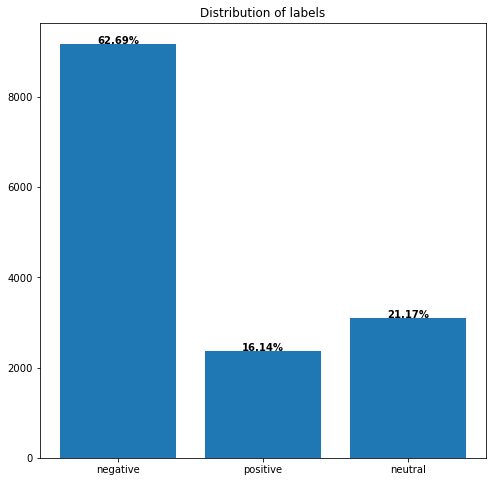

In [6]:
counts_before = percentage(data_n, class_n = 3)

In [7]:
data_else = data_n[data_n['airline_sentiment']!="negative"]

In [8]:
data_negative = data_n[data_n['airline_sentiment']=="negative"]

{'negative': 6149, 'non-negative': 5462}


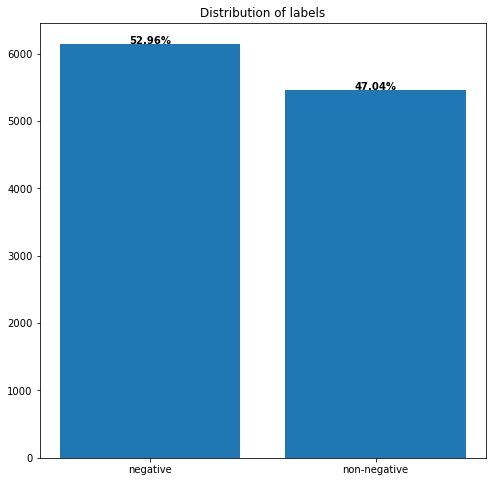

In [9]:
data_negative = data_negative.sample(frac = 0.67, replace = False)
data_n = pd.concat([data_negative, data_else])
data_n =data_n.reset_index()
data_n.drop(["index"], axis = 1, inplace = True)
counts_now = percentage(data_n, 2)

In [10]:
data_n

,airline_sentiment,text
0,negative,virginamerica what dhepburn said\n1 virginame...
1,negative,virginamerica what dhepburn said\n1 virginame...
2,negative,virginamerica what dhepburn said\n1 virginame...
3,negative,virginamerica what dhepburn said\n1 virginame...
4,negative,virginamerica what dhepburn said\n1 virginame...
...,...,...
11606,positive,virginamerica what dhepburn said\n1 virginame...
11607,neutral,virginamerica what dhepburn said\n1 virginame...
11608,positive,virginamerica what dhepburn said\n1 virginame...
11609,neutral,virginamerica what dhepburn said\n1 virginame...


text classification

In [11]:
data_n["label"] = ""
data_n["label"] = data_n["airline_sentiment"].apply(text_class)
data_n = data_n[['label', 'text']]

In [12]:
print(data_n.isnull().sum())

label    0
text     0
dtype: int64


In [13]:
data_n

,label,text
0,1,virginamerica what dhepburn said\n1 virginame...
1,1,virginamerica what dhepburn said\n1 virginame...
2,1,virginamerica what dhepburn said\n1 virginame...
3,1,virginamerica what dhepburn said\n1 virginame...
4,1,virginamerica what dhepburn said\n1 virginame...
...,...,...
11606,0,virginamerica what dhepburn said\n1 virginame...
11607,0,virginamerica what dhepburn said\n1 virginame...
11608,0,virginamerica what dhepburn said\n1 virginame...
11609,0,virginamerica what dhepburn said\n1 virginame...


Preparing for Bert Model

In [14]:
train, test =  train_test_split(data_n, test_size=0.05)

In [15]:
test.iloc[:,1]

9087      virginamerica what dhepburn said\n1 virginame...
10323     virginamerica what dhepburn said\n1 virginame...
8100      virginamerica what dhepburn said\n1 virginame...
3671      virginamerica what dhepburn said\n1 virginame...
1111      virginamerica what dhepburn said\n1 virginame...
                               ...                        
1232      virginamerica what dhepburn said\n1 virginame...
4841      virginamerica what dhepburn said\n1 virginame...
3569      virginamerica what dhepburn said\n1 virginame...
11596     virginamerica what dhepburn said\n1 virginame...
7661      virginamerica what dhepburn said\n1 virginame...
Name: text, Length: 581, dtype: object

In [16]:
print("For training dataset")
print(train.isnull().sum())
print("For testing dataset")
print(test.isnull().sum())

For training dataset
label    0
text     0
dtype: int64
For testing dataset
label    0
text     0
dtype: int64


In [21]:
x_train = train['text']
y_train = train['label']
x_test = test['text']
y_test = test['label']

Bert Model

Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed

In [24]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from keras.optimizers import Adam
import os
import shutil
from keras.models import  Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding
from transformers import AutoTokenizer, MobileBertModel


In [25]:
from transformers import MobileBertConfig, MobileBertModel
# Source: https://huggingface.co/docs/transformers/model_doc/mobilebert
# Initializing a MobileBERT configuration
configuration = MobileBertConfig()

# Initializing a model (with random weights) from the configuration above
model = MobileBertModel(configuration)

# Accessing the model configuration
configuration = model.config

In [26]:
# mobile bert model
tokenizer = AutoTokenizer.from_pretrained("google/mobilebert-uncased")
model = MobileBertModel.from_pretrained("google/mobilebert-uncased")

ConnectionError: HTTPSConnectionPool(host='cdn-lfs.huggingface.co', port=443): Read timed out.

In [22]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")


#tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

NameError: name 'torchtext' is not defined

In [37]:
from transformers import TFBertModel

In [38]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
x_train_tokens =  tokenizer(
        text = list(x_train),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )

In [39]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
x_test_tokens = tokenizer(
        text = list(x_test),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )

In [40]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [41]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
def bert_model(bert, n_layer = 64, dropout_rate = 0.2, length = 100):
    input_ids = Input(shape = (length,), dtype = tf.int32, name = 'input_ids')
    input_mask = Input(shape = (length,), dtype = tf.int32, name = 'input_mask')
    embeddings = bert([input_ids, input_mask])[1] #pooler output
    print(embeddings)
    out = Dropout(dropout_rate)(embeddings)
    out = Dense(n_layer,activation = 'relu')(out)
    out = Dropout(dropout_rate)(out)
    y = Dense(1,activation = 'sigmoid')(out)
    model = Model(inputs=[input_ids, input_mask], outputs=y)
    model.layers[2].trainable = True
    optimizer = Adam(learning_rate=9*10**-6, epsilon=10**-8, decay=0.01,clipnorm=1.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')
    return model

In [42]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
form_bert_model = bert_model(bert)

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


In [43]:
from keras.callbacks import EarlyStopping
history = form_bert_model.fit(x = {'input_ids':x_train_tokens["input_ids"],
                                   'input_mask':x_train_tokens['attention_mask']}, 
                                   y = y_train, epochs= 1, validation_split = 0.2, 
                                   batch_size = 128, callbacks=[EarlyStopping(monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)])

71/71 [==============================] - 3956s 55s/step - loss: 0.7167 - accuracy: 0.5063 - val_loss: 0.6925 - val_accuracy: 0.5317


In [44]:
# Source: https://pub.towardsai.net/fake-news-detection-using-bert-model-python-de005c5809ed
y_predict = np.where(form_bert_model.predict({ 'input_ids' : x_test_tokens['input_ids'] , 'input_mask' : x_test_tokens['attention_mask']}) >=0.5,1,0)

19/19 [==============================] - 56s 3s/step


Evaluation 

In [45]:
def evaluation(y_predict, y_test):
    from sklearn.metrics import confusion_matrix
    acc = np.mean(y_predict==y_test)
    ccm = confusion_matrix(y_predict, y_test)
    return {"confusion matrix": ccm, "accuracy": acc} 

In [46]:
eval = evaluation(y_predict, y_test.values)

In [47]:
eval

{'confusion matrix': array([[  0,   0],
        [255, 340]]),
 'accuracy': 0.5714285714285714}

In [48]:
yhat = pd.DataFrame(y_predict)

In [49]:
precision = eval['confusion matrix'][1][1]/(eval['confusion matrix'][1][1]+eval['confusion matrix'][1][0])
recall = eval['confusion matrix'][1][1]/(eval['confusion matrix'][1][1]+eval['confusion matrix'][0][1])
f1_score = 2*(precision*recall)/(precision+recall)

In [50]:
print("accuracy =",  round(eval['accuracy']*100, 2), "%, F-1 score = ", round(f1_score*100, 2), "%")

accuracy = 57.14 %, F-1 score =  72.73 %
